In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt \
    -O /content/irish-lyrics.txt

--2020-07-31 00:45:15--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘/content/irish-lyrics.txt’

/content/irish-lyri 100%[===================>]  67.35K  --.-KB/s    in 0s      

2020-07-31 00:45:15 (135 MB/s) - ‘/content/irish-lyrics.txt’ saved [68970/68970]



In [ ]:
wFile = open('irish-lyrics.txt', 'r').read()
corpus = wFile.lower().split('\n')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
w2i = tokenizer.word_index

In [ ]:
ngrams = []

for line in corpus:
  enc = tokenizer.texts_to_sequences([line])[0]
  for i in range(1,len(enc)):
    ngram = enc[:i+1]
    ngrams.append(ngram)

In [ ]:
mlen = max([len(x) for x in ngrams])
padded = pad_sequences(ngrams, maxlen = mlen, padding = 'pre', truncating='pre')

In [ ]:
print(mlen)

16


In [ ]:
padded = np.array(padded)
print(padded.shape)

(12038, 16)


In [ ]:
x = padded[:,:-1]
y = padded[:,-1]

In [ ]:
print(y)

[  12   96 1217 ...  105  138  184]


In [ ]:
num_vocab = len(w2i)

In [ ]:
y = tf.keras.utils.to_categorical(y,num_classes=num_vocab + 1)

In [ ]:
#So you can slice a dictionary
d = {x:w2i[x] for x in list(w2i)[:10]}
print(d)

{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10}


In [ ]:
model = Sequential([
                    Embedding(input_dim=num_vocab+1, output_dim = 100, input_length=mlen-1),
                    Bidirectional(LSTM(150)),
                    Dense(num_vocab+1, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics=['accuracy'])

In [ ]:
class mycallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') > 0.95):
      self.model.stop_training = True
      print('95% accuracy reached')

In [ ]:
callback = mycallback()
history = model.fit(x, y, epochs=30, verbose=1, callbacks=callback)

Epoch 1/30
377/377 [==============================] - 3s 9ms/step - loss: 2.0813 - accuracy: 0.5187
Epoch 2/30
377/377 [==============================] - 4s 9ms/step - loss: 1.7287 - accuracy: 0.5794
Epoch 3/30
377/377 [==============================] - 4s 9ms/step - loss: 1.4018 - accuracy: 0.6547
Epoch 4/30
377/377 [==============================] - 3s 9ms/step - loss: 1.2614 - accuracy: 0.6833
Epoch 5/30
377/377 [==============================] - 4s 9ms/step - loss: 1.1815 - accuracy: 0.7054
Epoch 6/30
377/377 [==============================] - 4s 9ms/step - loss: 1.1621 - accuracy: 0.7092
Epoch 7/30
377/377 [==============================] - 3s 9ms/step - loss: 1.1830 - accuracy: 0.7029
Epoch 8/30
377/377 [==============================] - 3s 9ms/step - loss: 1.2941 - accuracy: 0.6766
Epoch 9/30
377/377 [==============================] - 4s 9ms/step - loss: 1.3656 - accuracy: 0.6594
Epoch 10/30
377/377 [==============================] - 3s 9ms/step - loss: 1.3754 - accuracy: 0.6610

In [ ]:
def plot(model, metric):
  met = model.history[metric]
  plt.plot(met)
  plt.xlabel('epochs')
  plt.ylabel(metric)
  plt.show()

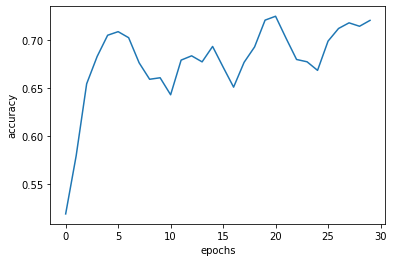

In [ ]:
plot(history, 'accuracy')

In [ ]:
rev_word_idx = {w2i[i]:i for i in list(w2i)}

In [ ]:
sen = 'I am a dog'
next_words  = 10

for _ in range(next_words):
  enc = tokenizer.texts_to_sequences([sen])[0]
  padded = pad_sequences([enc], maxlen=mlen-1, padding='pre', truncating='pre')
  pred_class = model.predict_classes(padded)
  pred_word = ''
  for i in rev_word_idx:
    if i == pred_class:
      pred_word = rev_word_idx[i]
      break
  sen = f'{sen} {pred_word}'

print(sen)

I am a dog little beggarman a begging i have been a young strength


In [ ]:
pred_class

array([112])

In [ ]:
model.save('f.h5')